In [34]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms,utils
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [35]:
transform = transforms.Compose(
    [transforms.Grayscale(),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   #needed to do grayscale cob=nversion before normalizing to tensor
trainset=datasets.CIFAR10('CIFAR10/',train=True,transform=transform,download=True)
train_loader=DataLoader(trainset,batch_size=64,shuffle=True)

testset=datasets.CIFAR10('CIFAR10/',train=False,transform=transform,download=True)
test_loader=DataLoader(testset,batch_size=64,shuffle=True)
   #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

Files already downloaded and verified
Files already downloaded and verified


torch.Size([64, 1, 32, 32])
torch.Size([64])


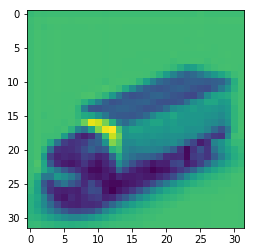

In [36]:
image,label=next(iter(train_loader))
print(image.size())
print(label.size())
plt.imshow(image[0][0,:])

In [37]:
label

tensor([ 9,  8,  8,  3,  1,  8,  2,  5,  1,  7,  7,  7,  9,  1,
         5,  1,  0,  5,  1,  9,  9,  7,  8,  1,  7,  0,  4,  6,
         5,  4,  7,  9,  4,  3,  9,  8,  1,  1,  5,  6,  7,  0,
         0,  8,  4,  2,  3,  1,  0,  7,  4,  0,  0,  6,  9,  5,
         7,  8,  4,  5,  4,  0,  3,  7])

In [38]:
class Network(torch.nn.Module):
    
    def __init__(self):
        super(Network,self).__init__()
        self.fc1=torch.nn.Linear(1024,600)
        self.dropout1=torch.nn.Dropout(p=0.2)
        self.fc2=torch.nn.Linear(600,400)
        self.fc3=torch.nn.Linear(400,200)
        self.dropout2=torch.nn.Dropout(p=0.2)
        self.fc4=torch.nn.Linear(200,100)
        self.fc5=torch.nn.Linear(100,10)
        #self.sigmoid=torch.nn.Sigmoid()
        
        
    def forward(self,x):
        
        x=x.view(-1,1024)  #flatten in forward instead of train
        out1=F.relu(self.fc1(x))
        out1=self.dropout1(out1)
        out2=F.relu(self.fc2(out1))
        out2=self.dropout2(out2)
        out3=F.relu(self.fc3(out2))
        out4=F.relu(self.fc4(out3))   #sof max at end, or sigmoid all the way did not work out
        #y_pred=F.softmax(out4,dim=1)   #if don't need probability as out put not necessary output4 is batch_size*10
        y_pred=F.relu(self.fc5(out4))
        return y_pred

model=Network()    
    

In [39]:
epochs=50
criterion=torch.nn.CrossEntropyLoss()  #if increase the lr to 0.1, it kicks to local min and stays
optimizer=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)  #had to change from SGD to Adam but later noy much difference
lr_scheduler_=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#lr_scheduler_=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs)

In [40]:
#torch.set_printoptions(precision=2)
def train_function(train_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0

    for epoch in range(epochs):

        for input,label in iter(train_loader):

            #input.resize_(input.size()[0], 784)   take to forward
            y_pred=model(input)   #this is 64 (bacth_size)*10

            if(count==0): print(y_pred.size(),label.size())
            loss=criterion(y_pred,label)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
            loss_running=loss_running+loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count=count+1
            #y_pred_round=torch.round(y_pred)
            count_batch=count_batch+(label.size()[0])
            _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

            acc=(label==y_pred_).sum().item()    #/label.size()[0]
            sum_acc=sum_acc+acc
            if(count%1000==0): print('epoch',epoch+1,'/',epochs,'running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))

        check_loss=(loss_running/count_batch)
        lr_scheduler_.step(check_loss)

train_function(train_loader)

torch.Size([64, 10]) torch.Size([64])
epoch 2 / 50 running_loss: 0.03341938165282798 Accuracy 21.838253690267702
epoch 3 / 50 running_loss: 0.030685147154523577 Accuracy 28.886508631473607
epoch 4 / 50 running_loss: 0.02905039086760199 Accuracy 33.04822366775081
epoch 6 / 50 running_loss: 0.02790280544957333 Accuracy 35.888332812011264
epoch 7 / 50 running_loss: 0.02699657999066342 Accuracy 38.13119307376639
epoch 8 / 50 running_loss: 0.02626453789965594 Accuracy 39.875776721297804
epoch 9 / 50 running_loss: 0.025615619516017728 Accuracy 41.407813840434656
epoch 11 / 50 running_loss: 0.02502154796327469 Accuracy 42.81337973099781
epoch 12 / 50 running_loss: 0.024483871664687736 Accuracy 44.07286540439848
epoch 13 / 50 running_loss: 0.0239873404314751 Accuracy 45.25713767390651
epoch 15 / 50 running_loss: 0.02352912097867968 Accuracy 46.33499590518222
epoch 16 / 50 running_loss: 0.02307967707987076 Accuracy 47.370190803878636
epoch 17 / 50 running_loss: 0.02266566229976707 Accuracy 48.3

In [41]:
#torch.set_printoptions(precision=2)
def test_function(test_loader):
    loss_running=0
    count=0
    count_batch=0
    sum_acc=0



    for input,label in iter(test_loader):
        model.eval()

        #input.resize_(input.size()[0], 784)   take to forward
        y_pred=model(input)   #this is 64 (bacth_size)*10

        #if(count==0): print(y_pred.size(),label.size())
        loss=criterion(y_pred,label)    #criterion(y_pred,label), crossentropy criterion need long (output of forward) and normal tensor (target)
        loss_running=loss_running+loss.item()
        count=count+1

        count_batch=count_batch+(label.size()[0])
        _,y_pred_=torch.max(y_pred,dim=1)    #argmax is the second value returned by torch.max()  ,this collapse dimension to batch size with argmax of probabililty/value (second) item, first one is the value itself 

        acc=(label==y_pred_).sum().item()    #/label.size()[0]
        sum_acc=sum_acc+acc
        if(count%100==0): print('running_loss:',(loss_running/count_batch),'Accuracy',(sum_acc*100/count_batch))




test_function(test_loader)   #result show over fitting on train, bu toverall 50% is not too bad wihtout convnet

running_loss: 0.02918641835451126 Accuracy 48.9375
